In [88]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense, Dropout, regularizers
from keras.layers import LSTM


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_length = 24000
stock = '9062'
gdf_filename_pattern = 'gdf_{}_r{}_s{}_K50'
gdf_parameters = [(0.1, 0.1), (0.01, 0.1), (0.1, 0.5), (0.01, 0.5)]

In [150]:
df_log = pd.read_csv('../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
29,0.057241,0.528676,0.047951,0.524117,0.062033,0.531175,0.066864,0.533577


In [3]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, data_dir='~/shit2',
        gdf_filename_pattern=gdf_filename_pattern))

In [4]:
gdf_dfs[0].df.columns

Index(['Unnamed: 0', 'datetime', 'gdf_0', 'gdf_1', 'gdf_10', 'gdf_11',
       'gdf_12', 'gdf_13', 'gdf_14', 'gdf_15', 'gdf_16', 'gdf_17', 'gdf_18',
       'gdf_19', 'gdf_2', 'gdf_20', 'gdf_21', 'gdf_22', 'gdf_23', 'gdf_24',
       'gdf_25', 'gdf_26', 'gdf_27', 'gdf_28', 'gdf_29', 'gdf_3', 'gdf_30',
       'gdf_31', 'gdf_32', 'gdf_33', 'gdf_34', 'gdf_35', 'gdf_36', 'gdf_37',
       'gdf_38', 'gdf_39', 'gdf_4', 'gdf_40', 'gdf_41', 'gdf_42', 'gdf_43',
       'gdf_44', 'gdf_45', 'gdf_46', 'gdf_47', 'gdf_48', 'gdf_49', 'gdf_5',
       'gdf_6', 'gdf_7', 'gdf_8', 'gdf_9', 'mid_price', 'mid_price_indicator',
       'queue_imbalance', 'bid_price', 'ask_price', 'prev_queue_imbalance'],
      dtype='object')

In [117]:
df = gdf_dfs[2].df
df_test = gdf_dfs[2].df_test
n_components = gdf_dfs[2].get_pca('pca_n_gdf_que_prev').n_components_
class_weights = gdf_dfs[2].get_classes_weights()
print(n_components, class_weights)

3 {0.0: 0.9082694673100578, 1.0: 1.11234067207416}


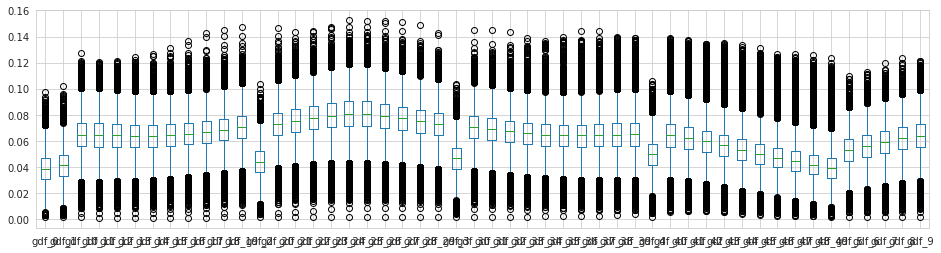

In [118]:
df[[c for c in df.columns if 'gdf' in c]].boxplot(figsize=(16, 4))

In [19]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper
import tensorflow as tf
auc_roc = as_keras_metric(tf.metrics.auc)

In [119]:
X_train = df[[gdf for gdf in df.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_train = df['mid_price_indicator'].values

print(n_components)
pca = PCA(n_components=n_components)
pca.fit(X_train)
X_train = pca.transform(X_train)

X_test = df_test[[gdf for gdf in df_test.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_test = df_test['mid_price_indicator'].values
X_test = pca.transform(X_test)

print(X_train.shape)
print(X_test.shape)


3
(19199, 3)
(4799, 3)


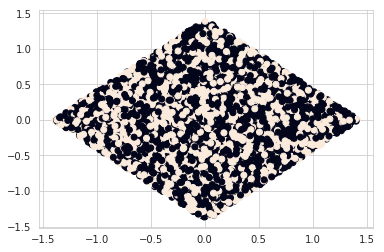

In [120]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [121]:
max_features = 1024
model = Sequential()
# model.add(LSTM(6))
model.add(Dense(8, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(rate=0.25))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

model.fit(X_train, y_train, shuffle=False, 
          epochs=4, batch_size=50, class_weight=class_weights)
print(model.summary())

Epoch 1/4
19199/19199 [==============================] - 15s 805us/step - loss: 0.6970 - auc: 0.5272
Epoch 2/4
19199/19199 [==============================] - 8s 415us/step - loss: 0.6941 - auc: 0.5234
Epoch 3/4
19199/19199 [==============================] - 8s 413us/step - loss: 0.6925 - auc: 0.5246
Epoch 4/4
19199/19199 [==============================] - 8s 415us/step - loss: 0.6924 - auc: 0.5267
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_137 (Dense)            (None, 8)                 32        
_________________________________________________________________
dense_138 (Dense)            (None, 16)                144       
_________________________________________________________________
dense_139 (Dense)            (None, 32)                544       
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_____

In [122]:
pred_test = model.predict_classes(X_test)
pred = model.predict_classes(X_train)

print(metrics.roc_auc_score(y_test, pred_test), metrics.roc_auc_score(y_train, pred))
print(metrics.matthews_corrcoef(y_test, pred_test), metrics.matthews_corrcoef(y_train, pred))

0.5179348722219899 0.5292410673906186
0.03713836599936981 0.06220184117841557


In [126]:
model = Sequential()
model.add(LSTM(6))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

In [127]:
epochs = 3
batch_size = 10
score = gdf_dfs[2].train_lstm(
    model, feature_name='que', plot_name='here.png',
    fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 1, 'shuffle': False}, 
    class_weight=class_weights,
    compile_kwargs= { 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': [auc_roc]})

Epoch 1/3
8725/8725 [==============================] - 13s 1ms/step - loss: 0.6904 - auc: 0.5458
Epoch 2/3
8725/8725 [==============================] - 4s 465us/step - loss: 0.6897 - auc: 0.5486 1s - loss: 0
Epoch 3/3
8725/8725 [==============================] - 3s 396us/step - loss: 0.6893 - auc: 0.5481
Epoch 1/3
8725/8725 [==============================] - 11s 1ms/step - loss: 0.6896 - auc: 0.5496
Epoch 2/3
8725/8725 [==============================] - 2s 225us/step - loss: 0.6896 - auc: 0.5480
Epoch 3/3
8725/8725 [==============================] - 2s 252us/step - loss: 0.6896 - auc: 0.5475
Epoch 1/3
8725/8725 [==============================] - 15s 2ms/step - loss: 0.6896 - auc: 0.5386
Epoch 2/3
8725/8725 [==============================] - 3s 377us/step - loss: 0.6896 - auc: 0.5450
Epoch 3/3
8725/8725 [==============================] - 3s 301us/step - loss: 0.6896 - auc: 0.5450
Epoch 1/3
8725/8725 [==============================] - 12s 1ms/step - loss: 0.6899 - auc: 0.5388
Epoch 2/3
8

In [128]:
score

{'precision': 0.48078399240548214,
 'f1': 0.4951621610855529,
 'recall': 0.5117284686732922,
 'roc_auc': 0.5287147738330024,
 'kappa': 0.057134601024832386,
 'matthews': 0.057290024233485295,
 'train_val_precision': 0.4821217747265264,
 'train_val_f1': 0.5056294422314384,
 'train_val_recall': 0.5318953323073748,
 'train_val_roc_auc': 0.533843056803835,
 'train_val_kappa': 0.06704884507492123,
 'train_val_matthews': 0.06738439157309774,
 'train_precision': 0.48281114012184506,
 'train_f1': 0.49803613511390415,
 'train_recall': 0.514252607184241,
 'train_roc_auc': 0.5322232853311687,
 'train_kappa': 0.06406387578862038,
 'train_matthews': 0.06417490015487604,
 'stock': '9062',
 'kernel': 'lstm',
 'features': 'que',
 'pca_components': None,
 'test_precision': 0.46881720430107526,
 'test_f1': 0.48857014791573283,
 'test_recall': 0.5100608329433786,
 'test_roc_auc': 0.5230619716933271,
 'test_kappa': 0.045727254792748306,
 'test_matthews': 0.04586922377300537}

In [ ]:
# More time steps

In [129]:
def split_sequences(sequences, labels, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x = sequences[i:end_ix] 
        lab = labels[end_ix-1]
        X.append(seq_x)
        y.append(lab)
    return np.array(X), np.array(y)

In [130]:
X_train = df[[gdf for gdf in df.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_train = df['mid_price_indicator'].values
pca = PCA(n_components=n_components)
pca.fit(X_train)
X_train = pca.transform(X_train)

X_test = df_test[[gdf for gdf in df_test.columns if 'gdf' in gdf or 'queue' in gdf]].values
y_test = df_test['mid_price_indicator'].values
X_test = pca.transform(X_test)

X_train, y_train = split_sequences(X_train, y_train, n_steps=5)
X_test, y_test = split_sequences(X_test, y_test, n_steps=5)



#X_test= np.reshape(X_test, (X_test.shape[0], 1, 3))
#X_train = np.reshape(X_train, (X_train.shape[0], 1, 3))
print(X_train.shape)
print(X_test.shape)

(19195, 5, 3)
(4795, 5, 3)


In [146]:
max_features = 1024
model = Sequential()
model.add(LSTM(128, input_shape=(5, 3)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

model.fit(X_train, y_train, shuffle=False, 
          epochs=7, batch_size=50, class_weight=class_weights)
print(model.summary())

Epoch 1/7
19195/19195 [==============================] - 31s 2ms/step - loss: 0.6916 - auc: 0.5256
Epoch 2/7
19195/19195 [==============================] - 9s 483us/step - loss: 0.6909 - auc: 0.5365
Epoch 3/7
19195/19195 [==============================] - 10s 504us/step - loss: 0.6908 - auc: 0.5375
Epoch 4/7
19195/19195 [==============================] - 9s 477us/step - loss: 0.6908 - auc: 0.5381
Epoch 5/7
19195/19195 [==============================] - 10s 523us/step - loss: 0.6908 - auc: 0.5384
Epoch 6/7
19195/19195 [==============================] - 11s 594us/step - loss: 0.6907 - auc: 0.5388
Epoch 7/7
19195/19195 [==============================] - 10s 511us/step - loss: 0.6907 - auc: 0.5390
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 128)               67584     
_________________________________________________________________
dense_173 (Dense)            (Non

In [148]:
pred_test = model.predict_classes(X_test)
pred = model.predict_classes(X_train)

print(metrics.roc_auc_score(y_test, pred_test), metrics.roc_auc_score(y_train, pred))
print(metrics.matthews_corrcoef(y_test, pred_test), metrics.matthews_corrcoef(y_train, pred))

0.5231634413903612 0.5311473877155106
0.046179426330006275 0.06291341882450528


In [142]:
## With validation

In [202]:
model = Sequential()
model.add(LSTM(512, input_shape=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

In [203]:
epochs = 3
batch_size = 25
score = gdf_dfs[0].train_lstm(
    model, feature_name='pca_n_gdf_que_prev', plot_name='here.png', n_steps=2,
    fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 1, 'shuffle': False}, 
    class_weight=class_weights,
    compile_kwargs= { 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': [auc_roc]})

Epoch 1/3
8725/8725 [==============================] - 37s 4ms/step - loss: 0.6933 - auc: 0.5133
Epoch 2/3
8725/8725 [==============================] - 19s 2ms/step - loss: 0.6923 - auc: 0.5215
Epoch 3/3
8725/8725 [==============================] - 19s 2ms/step - loss: 0.6924 - auc: 0.5232
Epoch 1/3
8725/8725 [==============================] - 38s 4ms/step - loss: 0.6933 - auc: 0.5130
Epoch 2/3
8725/8725 [==============================] - 17s 2ms/step - loss: 0.6935 - auc: 0.5065
Epoch 3/3
8725/8725 [==============================] - 17s 2ms/step - loss: 0.6929 - auc: 0.5071
Epoch 1/3
8725/8725 [==============================] - 34s 4ms/step - loss: 0.6933 - auc: 0.4734
Epoch 2/3
8725/8725 [==============================] - 17s 2ms/step - loss: 0.6931 - auc: 0.4915
Epoch 3/3
8725/8725 [==============================] - 17s 2ms/step - loss: 0.6931 - auc: 0.4929
Epoch 1/3
8725/8725 [==============================] - 34s 4ms/step - loss: 0.6930 - auc: 0.4849
Epoch 2/3
8725/8725 [=========

In [204]:
score['matthews'], score['test_matthews'], score['roc_auc'], score['test_roc_auc']

(0.00843709030374834, 0.0, 0.5042339016032436, 0.5)

In [205]:
model = Sequential()
model.add(LSTM(8, input_shape=(2, 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

In [208]:
epochs = 3
batch_size = 25
score = gdf_dfs[1].train_lstm(
    model, feature_name='pca_n_gdf_que', plot_name='here.png', n_steps=2,
    fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 1, 'shuffle': False}, 
    class_weight=class_weights,
    compile_kwargs= { 'loss': 'binary_crossentropy', 'optimizer': 'adam', 'metrics': [auc_roc]})

Epoch 1/3
8725/8725 [==============================] - 48s 5ms/step - loss: 0.6892 - auc: 0.5493
Epoch 2/3
8725/8725 [==============================] - 7s 847us/step - loss: 0.6892 - auc: 0.5497
Epoch 3/3
8725/8725 [==============================] - 9s 1ms/step - loss: 0.6892 - auc: 0.5493
Epoch 1/3
8725/8725 [==============================] - 50s 6ms/step - loss: 0.6896 - auc: 0.5506
Epoch 2/3
8725/8725 [==============================] - 9s 978us/step - loss: 0.6896 - auc: 0.5472
Epoch 3/3
8725/8725 [==============================] - 7s 852us/step - loss: 0.6896 - auc: 0.5467
Epoch 1/3
8725/8725 [==============================] - 55s 6ms/step - loss: 0.6897 - auc: 0.5380
Epoch 2/3
8725/8725 [==============================] - 11s 1ms/step - loss: 0.6897 - auc: 0.5440
Epoch 3/3
8725/8725 [==============================] - 7s 856us/step - loss: 0.6897 - auc: 0.5439
Epoch 1/3
8725/8725 [==============================] - 59s 7ms/step - loss: 0.6899 - auc: 0.5395
Epoch 2/3
8725/8725 [======

In [209]:
score['matthews'], score['test_matthews'], score['roc_auc'], score['test_roc_auc']

(0.058865640163601886,
 0.05058573811750905,
 0.5293542807878525,
 0.5253009480073275)

In [210]:
score = {**score, 'arch': model.to_json(), 'batch_size': batch_size, 'n_steps': 2, 'epochs': epochs, 
         'r': gdf_dfs[1].r, 's': gdf_dfs[1].s}
pd.DataFrame([score]).to_csv(
    '../gdf_pca/res_lstm_weird/res_lstm_pca_que_{}_len24000_r{}_s{}.csv'.format(stock, gdf_dfs[1].r, gdf_dfs[1].s))